In [1]:
import numpy as np
from maelstrom import Maelstrom
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 300

In [2]:
t, y = np.loadtxt('data/kic9651065_lc.txt', usecols=(0,1)).T

In [187]:
ms = Maelstrom(t, y, max_peaks=5, fmin=10, fmax=48)



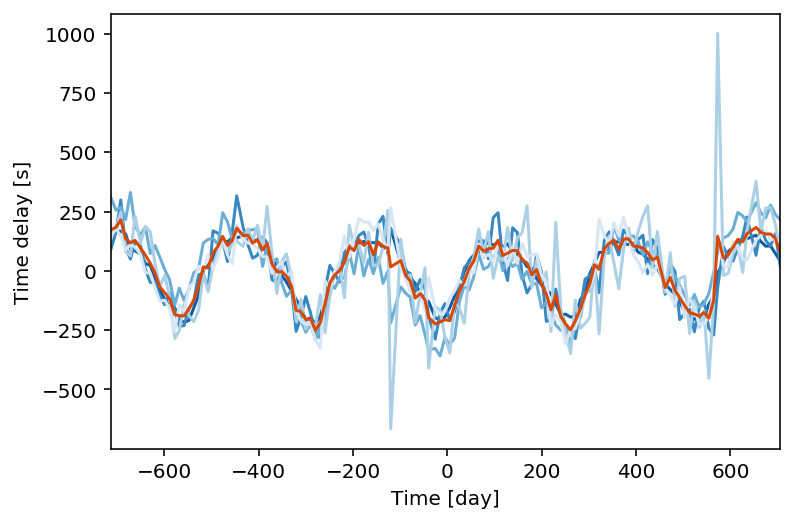

In [188]:
ms.plot_time_delay()

In [237]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
import pymc3 as pm

time_tensor = theano.shared(ms.time)
flux_tensor = theano.shared(ms.flux)
freqs = ms.freq

with pm.Model() as model:
    # Period
    logP = pm.Normal("logP", mu=np.log(272.), sd=0.5, shape=1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    drift = pm.Normal('drift_grad', mu=0.0, sd=0.01)
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(0.0001*np.median(np.abs(np.diff(flux_tensor.get_value())))), sd=10, testval=0.)
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(170)) 
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform('eccen', lower=1e-3, upper=0.99, testval=0.5)
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)
   
    # Mean anom
    M = 2.0 * np.pi * time_tensor / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + tt.zeros_like(M))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    logfreq = pm.Normal("lognu", mu=np.log(freqs), sd=0.1, shape=len(freqs))
    freq = pm.Deterministic("nu", tt.exp(logfreq))
    
    factor = 2. * np.pi * freq
    arg = (factor * (1 - drift)) * time_tensor[:, None]
    arg -= (factor * (tt.exp(logasini)) / 86400) * psi[:, None]
    
    sinarg = tt.sin(arg)
    cosarg = tt.cos(arg)
    DT = tt.concatenate((sinarg, cosarg), axis=-1).T
    
    w = pm.Normal("w", mu=0.0, sd=2.0, shape=len(freqs)*2,
                  testval=np.random.randn(len(freqs)*2))
    
    D = DT.T
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(D, w)
    
    logw0_guess = np.log(2*np.pi/1e-3)
    logw0 = pm.Normal("logw0", mu=logw0_guess, sd=1)
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux_tensor.get_value())) + 4*logw0_guess, sd=1)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))    
    gp = xo.gp.GP(kernel, time_tensor, tt.exp(2*logs_lc) + tt.zeros(len(time_tensor.get_value())), J=2)
    
    full_lc = lc_model + mean
    
    pm.Potential("obs", gp.log_likelihood(flux_tensor.get_value() - full_lc))

optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -376451.1817423445 -> -376451.1817418777
optimizing logp for variables: ['w']
message: Optimization terminated successfully.
logp: -376451.1817418777 -> -376434.2935037196
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -376434.2935037196 -> -376432.37877669965
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -376432.37877669965 -> -376411.8740254322
optimizing logp for variables: ['logpower', 'logw0']
message: Desired error not necessarily achieved due to precision loss.
logp: -376411.8740254322 -> -109401.71174264749
optimizing logp for variables: ['logpower', 'logw0', 'w', 'lognu', 'mean', 'eccen_interval__', 'omega_angle__', 'logasini_interval__', 'logs_lc', 'phi_angle__', 'drift_grad', 'logP']
message: Desired error not necessarily achieved due to

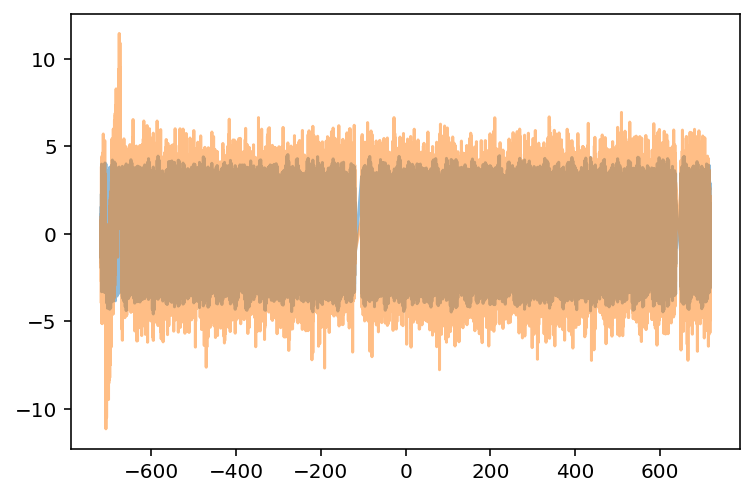

In [238]:
with model:
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[w])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[logw0, logpower])
    
    #map_params = xo.optimize(start=map_params, vars=[logfreq])
    
    map_params = xo.optimize(start=map_params)
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params)

    plt.plot(time_tensor.get_value(), xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time_tensor.get_value(), mag, alpha=0.5)

In [239]:
map_params

{'logP': array([5.60783226]),
 'drift_grad': array(-0.00016148),
 'phi_angle__': array([0.27934387, 4.53617852]),
 'logs_lc': array(-8.24777989),
 'logasini_interval__': array(1.12529992),
 'omega_angle__': array([-3.47872619,  2.6240685 ]),
 'eccen_interval__': array(-0.21332113),
 'mean': array(-0.00264574),
 'lognu': array([2.96910767, 3.07770984, 3.42741484, 2.87337028, 3.12195208]),
 'w': array([-1.05003802, -0.8458183 , -0.47286426,  0.60302165, -0.49799938,
         1.60921786,  0.06769502, -0.53591622, -0.01943029, -0.21324994]),
 'logw0': array(11.57462537),
 'logpower': array(35.56029342),
 'period': array([272.55277348]),
 'phi': array(0.06150366),
 'logasini': array(5.21515128),
 'asini': array(184.03965983),
 'omega': array(-0.92453692),
 'eccen': array(0.44295546),
 'nu': array([19.47453422, 21.7086293 , 30.7969247 , 17.6965602 , 22.69063043]),
 'phase': array(-2.46349972),
 'logS0': array(-10.73820805)}

In [230]:
map_params

{'logP': array([5.6062619]),
 'drift_grad': array(3.8077508e-05),
 'phi_angle__': array([0.12349155, 4.4704306 ]),
 'logs_lc': array(-8.24788419),
 'logasini_interval__': array(1.12697211),
 'omega_angle__': array([-3.6603684 ,  2.56937801]),
 'eccen_interval__': array(-0.23047637),
 'mean': array(-0.00064832),
 'lognu': array([2.96930718, 3.07790948, 3.42761451, 2.87356986, 3.12215176]),
 'w': array([-1.07938306, -0.86464818, -0.48641967,  0.61861105, -0.50604705,
         1.62916143,  0.07152969, -0.54400771, -0.01928116, -0.22276807]),
 'logw0': array(11.56606171),
 'logpower': array(35.56314802),
 'period': array([272.12510316]),
 'phi': array(0.02761706),
 'logasini': array(5.2172872),
 'asini': array(184.43317402),
 'omega': array(-0.95876605),
 'eccen': array(0.43876564),
 'nu': array([19.47841993, 21.71296348, 30.80307475, 17.70009232, 22.69516175]),
 'phase': array(-2.46620707),
 'logS0': array(-10.70109883)}

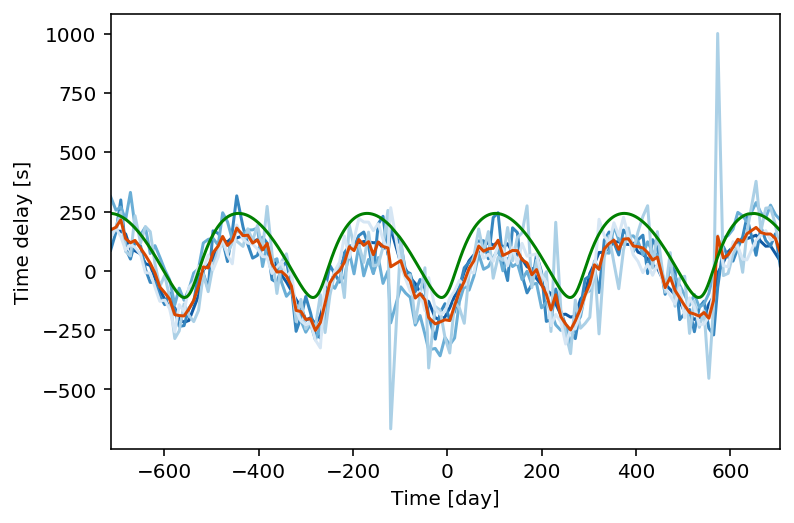

In [240]:
with model:
    fig, ax = plt.subplots()
    
    ms.plot_time_delay(ax=ax)
    ax.plot(ms.time, xo.eval_in_model(asini * psi, map_params), c='green')

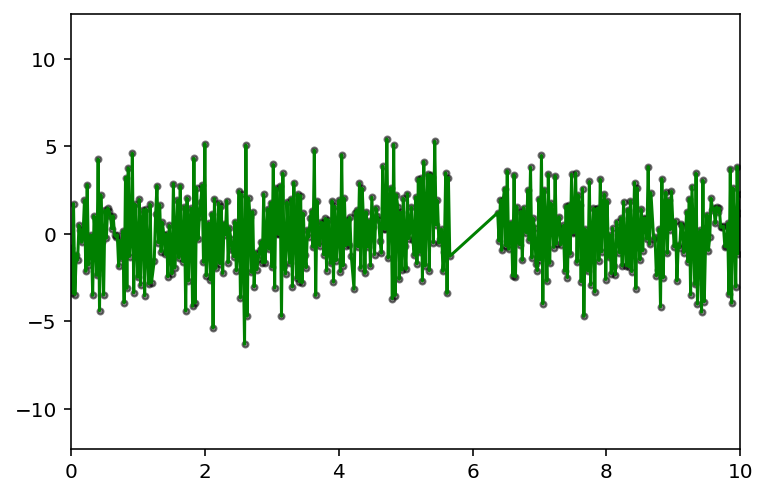

In [241]:
with model:
    
    plt.plot(ms.time, ms.flux, '.k', alpha=0.5)
    plt.plot(ms.time, xo.eval_in_model(lc_model + gp.predict(), map_params), c='green')
    plt.xlim(0,10)

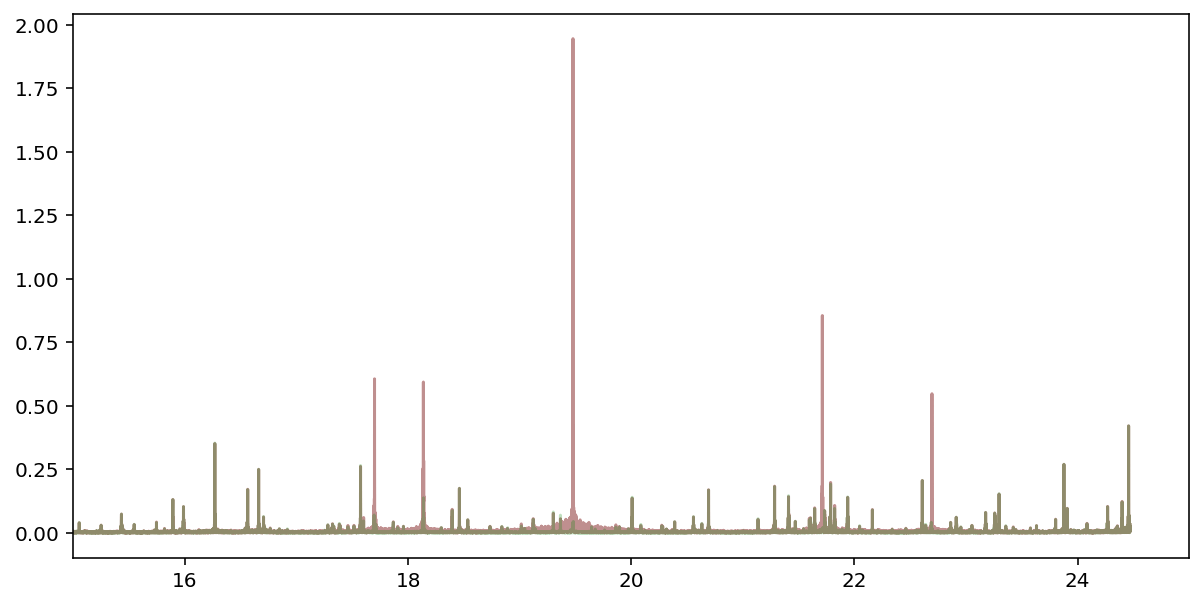

In [242]:
fig, ax = plt.subplots(figsize=[10,5])

from maelstrom.utils import amplitude_spectrum
with model:
    lc_lc = xo.eval_in_model(lc_model + gp.predict(), map_params)
    gp_lc = xo.eval_in_model(gp.predict(), map_params)
    plt.plot(*amplitude_spectrum(ms.time, lc_lc), alpha=0.25, c='red')
    plt.plot(*amplitude_spectrum(ms.time, ms.flux), alpha=0.25, c='black')
    plt.plot(*amplitude_spectrum(ms.time, gp_lc), alpha=0.25, c='green')
    plt.xlim(15,25)

In [247]:
model.profile()

TypeError: profile() missing 1 required positional argument: 'outs'

In [243]:
sampler = xo.PyMC3Sampler(start=50, window=300, finish=300)

with model:
    burnin = sampler.tune(tune=1000, start=map_params,
                          step_kwargs=dict(target_accept=0.9), chains=2)
    trace = sampler.sample(draws=1000, chains=1)

Sampling 2 chains:  81%|████████▏ | 492/604 [1:49:00<1:17:27, 41.50s/draws]


ValueError: Not enough samples to build a trace.

In [179]:
from astroquery.mast import Catalogs
a = Catalogs.query_object('KIC 4679562', catalog="Gaia", radius=0.001)

In [180]:
a

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance
str19,str28,str19,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64
1635721458409799680,Gaia DR2 2073636568737773824,2073636568737773824,783972004,2015.5,297.5567468358487,0.01122475401926668,39.78444528619365,0.01449906639860974,0.5923319031215034,0.014765556266498083,40.1157875,1.0347394496604476,0.024471930354895796,-0.7724384156083859,0.02763808551889765,0.0563251562,0.06490919,-0.135348573,-0.03216033,0.265010357,-0.06919886,-0.285056949,-0.141797647,0.027728552,0.0208075531,246,9,243,3,0.9563398,258.774963,0.0,0.0,31,False,127.003357,1.6621328965884614,0.0035360775105386768,0.05533755,28,16,0.03657496,0,31,False,263,99783.5506445371,25.47761567282224,3916.51831,13.1907187,30,59754.90202034212,60.999032682893386,979.604065,13.4104548,30,59602.18528254654,41.52029017633264,1435.49536,12.8237648,1.19616,0,0.586689949,0.2197361,0.36695385,--,--,0,--,--,--,NOT_AVAILABLE,74.46554137202385,6.792067785940586,313.81537176964866,59.10330929524028,100001,7157.25,6979.6665,7435.0,1.3587,1.053,1.487,0.6825,0.512,0.7531,200111,2.164772,2.006054,2.27633,11.0790834,10.2629147,11.8952522,0.00042347667979329126
1635721458409799680,Gaia DR2 2073636568726945920,2073636568726945920,1212320880,2015.5,297.55591263187245,20.229094291610735,39.78464665384848,17.182037613232946,--,--,--,--,--,--,--,-0.8365192,--,--,--,--,--,--,--,--,--,39,0,39,0,1.94631112,51.81963,3.2116392133852285,2.157500690911182,3,False,0.03049454,--,--,-0.136461124,5,3,10066.6113,0,5,False,39,161.17425799627625,6.1798667582422,26.08054,20.170126,0,--,--,--,--,0,--,--,--,--,--,1,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,74.46539543309234,6.792723905388779,313.814346809161,59.10372702183749,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.03993086417601

[logP, phi_angle__, logs_lc, omega_angle__, eccen_interval__, mean, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -85937718611.20186 -> -85937717346.41531
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -85937717346.41531 -> -153977.72926671646
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -153977.72926671646 -> -151983.5252234751
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Optimization terminated successfully.
logp: -151983.5252234751 -> -151983.50295787846
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -151983.50295787846 -> -130574.79640846042
optimizing logp for variables: ['phi_angle__']
message: Optimization terminate

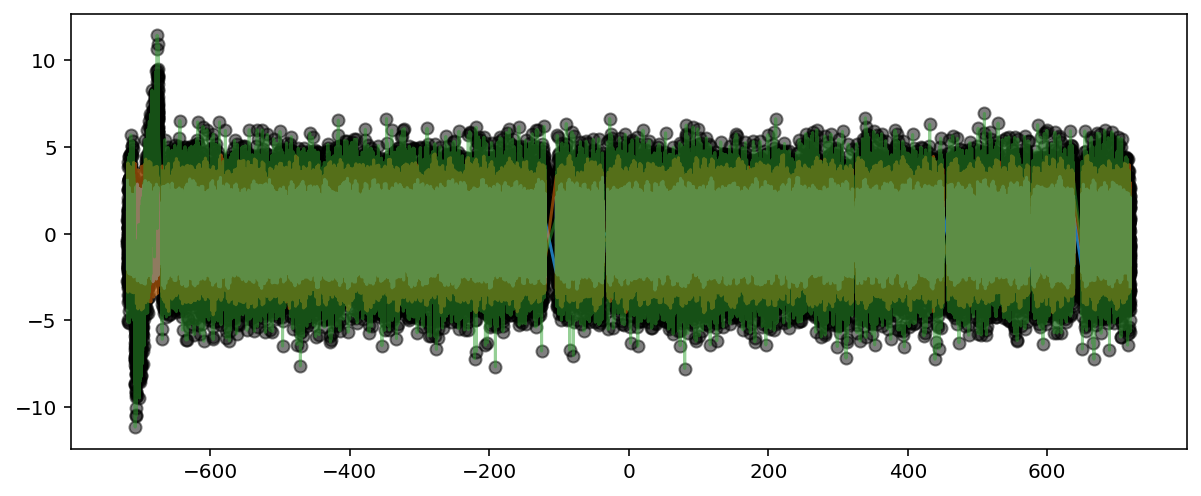

In [222]:
time, mag = ms.time, ms.flux
freq = ms.freq

with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(272.), sd=5., shape=1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=-7.78585661)
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(170)) 
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/1e-3))("logw0", mu=np.log(2*np.pi/0.1), sd=10,
                                                testval=np.log(2*np.pi/0.1))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=mag)

#     mag_sim = xo.eval_in_model(full_lc) + np.median(np.abs(np.diff(mag))) * np.random.randn(len(time))

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())


    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model))
    plt.scatter(time,mag, c='black', alpha=0.5)

with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [224]:
map_params

{'logP': array([5.60600091]),
 'phi_angle__': array([-0.02295128,  4.47208818]),
 'logs_lc': array(0.11886483),
 'logasini_interval__': array(1.09208835),
 'omega_angle__': array([-3.76516019,  2.41316438]),
 'eccen_interval__': array(-0.21804129),
 'mean': array(0.00316403),
 'lognu': array([2.96926909, 3.07787139, 3.42757642, 2.87353177, 3.12211367]),
 'phase_angle__': array([[-3.76275043, -0.43709768,  3.26688603,  0.2005193 ,  1.73204444],
        [-2.41684266, -4.45131218, -3.05404292,  4.46754456, -4.12326742]]),
 'logamp_interval__': array([ 3.19754647,  0.43993802,  0.13112601, -0.15574033, -0.35373432]),
 'logw0_interval__': array(-1.61057718),
 'logpower': array(-3.05867496),
 'period': array([272.05409215]),
 'phi': array(-0.00513207),
 'logasini': array(5.17235285),
 'asini': array(176.32922616),
 'omega': array(-1.00083113),
 'eccen': array(0.40113416),
 'nu': array([19.47767798, 21.71213655, 30.80190132, 17.69941826, 22.6942973 ]),
 'phase': array([-2.14174476, -3.0437112

In [220]:
np.log(2*np.pi/100.0),np.log(2*np.pi/0.1)

(-2.767293119578746, 4.140462159403391)

In [217]:
np.log(2*np.pi/1)

1.8378770664093453